In [2]:
%pip install --quiet gymnasium numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [218]:
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np

In [83]:
np.__version__

'2.2.0'

Directions: 0123 = up right down left


In [300]:
class CliffWalkEnv(gym.Env):
    DELTA = {
        0: np.array([-1, 0]),
        1: np.array([0, 1]),
        2: np.array([1, 0]),
        3: np.array([0, -1]),
    }
    TRUNCATE_TIME = 100

    def __init__(self):
        super().__init__()
        self.observation_space = spaces.MultiDiscrete([4, 11])
        self.action_space = spaces.Discrete(4)

        self._start = np.array([3, 0])
        self._goal = np.array([3, 10])

    def _clamp(self):
        i, j = self._state
        self._state = np.array([np.clip(i, 0, 3), np.clip(j, 0, 10)])

    def reset(self):
        self._state = self._start.copy()
        self._timesteps = 0
        self._total_rewards = 0
        return tuple(self._state), {}

    def step(self, action):
        self._state += CliffWalkEnv.DELTA[action]
        self._clamp()
        i, j = self._state
        if i == 3 and 1 <= j <= 9:
            reward = -100
            terminated = True
        else:
            reward = -1
            if np.array_equal(self._state, self._goal):
                terminated = True
            else:
                terminated = False
        self._timesteps += 1
        truncated = self._timesteps >= CliffWalkEnv.TRUNCATE_TIME
        if truncated:
            reward = -100
        self._total_rewards += reward

        return (
            tuple(self._state),
            reward,
            terminated,
            truncated,
            {"total_rewards": self._total_rewards} if terminated or truncated else {},
        )

In [284]:
env = CliffWalkEnv()
env.reset()

((np.int64(3), np.int64(0)), {})

In [298]:
env.step(2)

((np.int64(3), np.int64(10)), -1, True, False, {'total_rewards': -14})

In [332]:
alpha = 0.1
gamma = 1
epsilon = 0.1

# Sarsa
episodes = 500


env = CliffWalkEnv()
q = np.zeros((4, 11, 4))
vis = np.zeros((4, 11))


def epsilon_greedy(s):
    if np.random.random() < epsilon:
        return np.random.choice(range(4))
    return np.argmax(q[s])


def sarsa():
    episode_rewards = []
    for ep in range(episodes):
        s, _ = env.reset()
        vis[s] += 1
        a = epsilon_greedy(s)
        done = False
        while not done:
            s_prime, r, terminated, truncated, info = env.step(a)
            vis[s_prime] += 1
            a_prime = epsilon_greedy(s_prime)
            q[s + (a,)] += alpha * (r + gamma * q[s_prime + (a_prime,)] - q[s + (a,)])
            s = s_prime
            a = a_prime
            done = terminated or truncated
        episode_rewards.append(info["total_rewards"])


pi = np.argmax(q, axis=2)

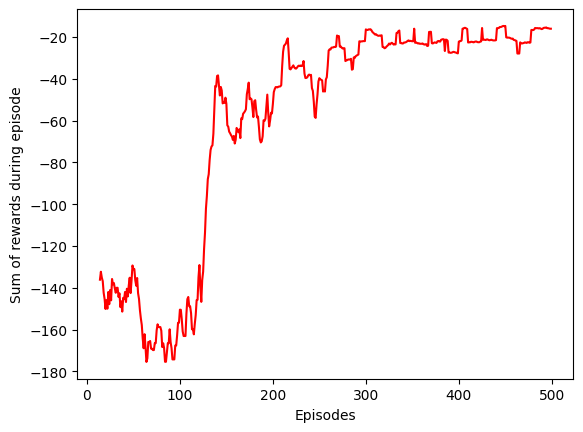

In [333]:
fig, ax = plt.subplots()

window_size = 15
kernel = np.ones(window_size) / window_size

ax.plot(
    range(window_size - 1, episodes),
    np.convolve(episode_rewards, kernel, "valid"),
    color="r",
)
ax.set_xlabel("Episodes")
ax.set_ylabel("Sum of rewards during episode")

plt.show()

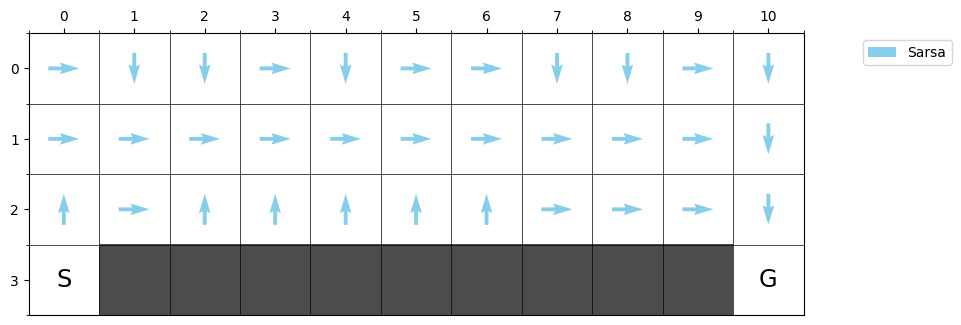

In [341]:
fig, ax = plt.subplots(figsize=(10, 6))

grid = np.ones_like(pi, dtype=float)
grid[3, 1:10] = 0.3

ax.imshow(grid, cmap="gray", vmin=0, vmax=1)

ax.text(0, 3, "S", ha="center", va="center", color="k", size="xx-large")
ax.text(10, 3, "G", ha="center", va="center", color="k", size="xx-large")


xv, yv = np.meshgrid(np.arange(11), np.arange(3))
dx = np.zeros_like(xv, dtype=float)
dy = np.zeros_like(yv, dtype=float)

DIR_X = {0: 0, 1: 1, 2: 0, 3: -1}
DIR_Y = {0: -1, 1: 0, 2: 1, 3: -0}

for i in range(3):
    for j in range(11):
        dx[i, j] = DIR_X[pi[i, j]]
        dy[i, j] = DIR_Y[pi[i, j]]

ax.quiver(
    xv,
    yv,
    dx,
    dy,
    color="skyblue",
    angles="xy",
    scale=25,
    width=5e-3,
    pivot="mid",
    label="Sarsa",
)


ax.set_xticks(range(11))
ax.set_yticks(range(4))
ax.set_xticks(np.arange(-0.5, pi.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, pi.shape[0], 1), minor=True)
ax.xaxis.tick_top()

ax.grid(which="minor", color="k", linewidth=0.5)
ax.legend(bbox_to_anchor=(1.2, 1))

plt.show()

In [335]:
np.round(np.max(q, axis=2))

array([[-17., -16., -15., -14., -13., -13., -10.,  -8.,  -9.,  -9.,  -5.],
       [-16., -15., -13., -12., -11.,  -9.,  -8.,  -7.,  -5.,  -4.,  -3.],
       [-17., -16., -15., -14., -13., -11., -11.,  -6.,  -4.,  -2.,  -1.],
       [-18.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])

In [336]:
vis

array([[647., 577., 504., 483., 417., 414., 335., 243., 220., 238., 305.],
       [940., 830., 695., 612., 584., 724., 678., 592., 502., 385., 367.],
       [948., 353., 272., 267., 195., 280., 188., 209., 342., 274., 408.],
       [792.,  39.,   8.,  10.,   7.,  10.,   3.,   7.,   7.,   9., 354.]])

In [263]:
q = np.zeros((4, 11, 4))
q[tuple(np.array([1, 2]))]
(1, 2), (3,)
# [np.random.choice(range(4)) for _ in range(100)]
# np.argmax(q[(3, 0)])
np.array([1, 2]) == np.array([1, 2])

array([ True,  True])

In [141]:
pi = np.random.randint(0, 4, (4, 11))
# pi[3][10]
pi
x, y = np.array([1, 2]) + np.array([1, 2])
x, y

(np.int64(2), np.int64(4))

In [124]:
pi

array([[2, 3, 2, 2, 0, 2, 2, 0, 3, 0, 0],
       [0, 3, 3, 2, 0, 1, 1, 2, 0, 1, 2],
       [2, 2, 3, 1, 0, 3, 2, 0, 3, 3, 3],
       [0, 3, 3, 1, 2, 0, 1, 2, 0, 0, 2]])

In [98]:
xv[2, 3]

np.int64(3)

In [59]:
grid.dtype

dtype('int64')